In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from zo_optimizer import ZOOptimizer


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def compute_loss(net, x, target):
    output = net(x)
    loss = F.mse_loss(output, target)
    return loss.detach_()

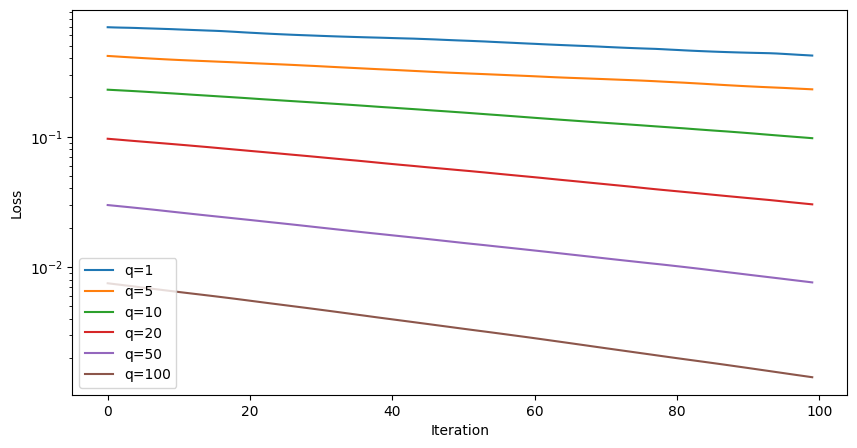

In [17]:
from matplotlib import pyplot as plt

# generate synthetic data
x = torch.randn(10).to('cuda')
target = torch.randn(1).to('cuda')

net = Net().to('cuda')
optimizer = ZOOptimizer(optim.Adam, net.parameters(), compute_loss, q=1, mu=1e-5, sides=1)


num_estimates = [1, 5, 10, 20, 50, 100]

plt.figure(figsize=(10, 5))

for q in num_estimates:
    optimizer.q = q
    losses = []
    for i in range(100):
        optimizer.step(net, x, target)
        with torch.no_grad():
            loss = compute_loss(net, x, target)
            losses.append(loss.item())
    plt.plot(losses, label=f'q={q}')

plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Text(0, 0.5, 'Loss')

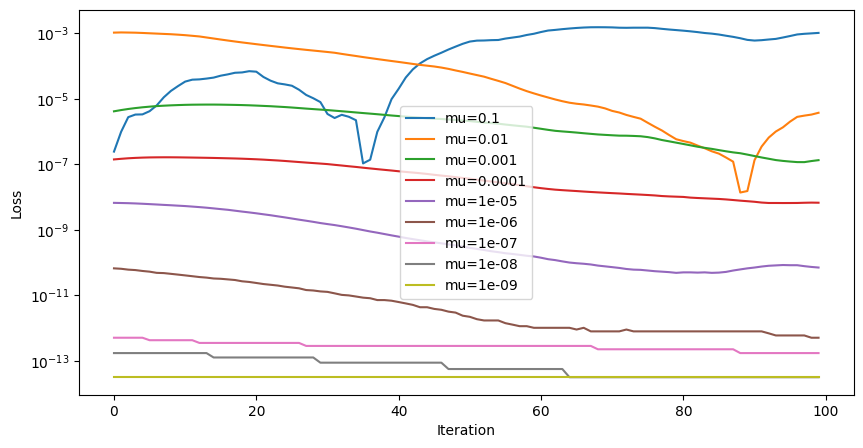

In [22]:
# compare multiple perturabation radii
radii = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

plt.figure(figsize=(10, 5))

optimizer.q = 5
for mu in radii:
    optimizer.mu = mu
    losses = []
    for i in range(100):
        optimizer.step(net, x, target)
        with torch.no_grad():
            loss = compute_loss(net, x, target)
            losses.append(loss.item())
    plt.plot(losses, label=f'mu={mu}')


plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')